# **Documentation of community coalescence**

## **Context**

1. **Project background**：
This project is part of a big new program titled ‘A new Green Revolution: Manipulating the soil microbiome to enhance the sustainability of 21st century agriculture,’. The current focus is to optimise/engineer soil microbiomes to suppress the fungus Gaeumannomyces tritici, which causes the **take-all disease** in wheat (T. aestivum).

2. **Microbial community coalescence**：
It is the process by which two distinct microbial communities encounter one another and interact to form a new ‘daughter’ community. This assemblage may more closely resemble one ‘parent’ community than the other, and its functional profile may be totally unique. We plan to use a coalescence method to ensure resistant community is intact in order to carry out its desired function in soil.


## **Obectives**

**Can we predict winners and losers during coalescence?**

This very basic question remains relatively un-explored. However, we did have some insights on community assembly. That is, species with higher CUE value tend to survive. And there is certain connection between species richness and CUE variance.

We will use the similiar methdology as community assembly to simulate the community dynamics during coalescence, mediated by temperature. By doing that, we hope to predict the result of community coalescence through carbon usage efficiency appearance of species in different temperature. The outcome of this research will give some foundamental information for the coalescence experiments and the dealing with take-all disease project.

**Microbial Consumer Resource Model**

$$
\frac{dC_i}{dt} = \sum_{\alpha=0}^{M} C_i R_{\alpha} u_{i\alpha} (1 - \lambda_{\alpha}) - C_i m_i
$$

$$
\frac{dR_{\alpha}}{dt} = \rho_{\alpha} - R_{\alpha} \omega_{\alpha} - \sum_{i=0}^{N} C_i R_{\alpha} u_{i\alpha} + \sum_{i=0}^{N} \sum_{\beta=0}^{M} C_i R_{\beta} u_{i\beta} l_{i\beta\alpha}
$$


| **Parameter** | **Description** | **Key** |
|--------------|---------------|--------|
| $C_i$ | Biomass of the $i$th consumer | - |
| $R_{\alpha}$ | Mass of the $\alpha$th resource | - |
| $N$ | Number of consumer populations | $N$ |
| $M$ | Number of resources | $M$ |
| $u_{i\alpha}$ | Uptake rate of the $\alpha$th resource by the $i$th consumer | $u$ |
| $m_i$ | Loss term for the $i$th consumer | $m$ |
| $\rho_{\alpha}$ | Inflow rate for the $\alpha$th resource | $\rho$ |
| $\omega_{\alpha}$ | Outflow term for the $j$th resource | $\omega$ |
| $l_{i\alpha\beta}$ | Proportion of uptake of the $\alpha$th resource leaked to the $\beta$th resource by $i$th consumer | $l$ |
| $\lambda_{\alpha}$ | Total proportion of the $\alpha$th resource leaked, same as $\sum_{\beta} l_{\alpha\beta}$ | $\lambda$ |


We adapt this model because it is able to capture the complex interactions of both competition for resources and the exchange of metabolic by-products.

## **Simulation:**

Import the packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.integrate import solve_ivp
import seaborn as sns
import sys
import os

In [10]:
sys.path.append(os.path.expanduser("~/Documents/MiCRM/code"))
import param_3D

`MiCRM` is the package for simulation of Microbial Consumer Resource (MiCRM) systems. It countains some aggregated functions.

Now we  *set system size and leakage rate*

In [11]:
# Parameters
N = 20 # Number of consumers
M = 12 # Number of resources
λ = 0.3  # Total leakage rate

N is the **number of species in a community**, M is the **number of resource types**, leakage is the overall leakage rate

Next, *make uptake matrix out of dirichlet distribution*

In [12]:
# Each consumer's uptake scaling factor
λ_u = np.random.uniform(0.8, 1, N)  
σ = np.random.uniform(0.05 * λ_u, 0.2 * λ_u)
N_modules = 5  # Number of modules connecting consumers to resources
s_ratio = 4.0  # Strength of modularity

In [13]:
# Generate uptake matrix, defining consumer-resource interaction strengths
u = param_3D.modular_uptake(N, M, N_modules, s_ratio, λ_u, σ)  

The N_modules determines how many different blocks of resources will be divided into, and s_ratio determines how much will species focus on inner group resources. *More details about this function see document of functions

*Define other terms*

In [14]:
# Mortality rate for each consumer
m = np.full(N, 0.2)  
# Input rate of each resource
rho = np.full(M, 1)  
# Decay rate for each resource
omega = np.full(M, 0.01)  

m is a loss term for the the consumers. It can be simply understood as the proportion of deceased organisms.

ρ is the resource inflow amount of the system and ω is outflow rate.

Next, we *make leakage matrix out of dirichlet distribution and make it modular*

In [15]:
# Total leakage rate for each resource
lambda_alpha = np.full(M, λ)
# Generate leakage tensor representing leakage flow between consumers and resources
l = param_3D.generate_l_tensor(N, M, N_modules, s_ratio, λ)  

We make it N times to generate a unique resource leakage matrix for each consumer. Similarly to the `MiCRM.Parameters.modular_uptake`, the N_modules determines how many the different blocks of resources will be divided into, and s_ratio determines the structure of leakage.

For now, we finished the parameter part and it is time to create an **Ordinary Differential Equation Problem** object which defines the problem for the ODE solver and then solve it with the aptly solve function.
To define the ODEProblem we need to specify the initial state of the system as well as the timespan

In [16]:
# ODE system describing the dynamics of consumers (C) and resources (R)
def dCdt_Rdt(t, y):
    C = y[:N]  # Consumer populations
    R = y[N:]  # Resource concentrations
    dCdt = np.zeros(N)
    dRdt = np.zeros(M)
    
    # Consumer growth equation
    for i in range(N):
        dCdt[i] = sum(C[i] * R[alpha] * u[i, alpha] * (1 - lambda_alpha[alpha]) for alpha in range(M)) - C[i] * m[i]
    
    # Resource depletion and leakage equation
    for alpha in range(M):
        dRdt[alpha] = rho[alpha] - R[alpha] * omega[alpha]  # Input and decay
        dRdt[alpha] -= sum(C[i] * R[alpha] * u[i, alpha] for i in range(N))  # Uptake by consumers
        dRdt[alpha] += sum(sum(C[i] * R[beta] * u[i, beta] * l[i, beta, alpha] for beta in range(M)) for i in range(N))  # Leakage contributions
    
    return np.concatenate([dCdt, dRdt])
    
# Initial conditions: assume all consumers and resources start at concentration 1
C0 = np.full(N, 0.1)
R0 = np.full(M, 1)
Y0 = np.concatenate([C0, R0])
    
t_span = (0, 700)
t_eval = np.linspace(*t_span, 300)
sol = solve_ivp(dCdt_Rdt, t_span, Y0, t_eval=t_eval)

x0 is an initial state, a one-dimensional array (vector) of length N+M, where all elements are initialized to 1.  

The initial time is 0.0 and the final time is 700

At last, we *visualize the dynamics of system* 

## **Visualization**

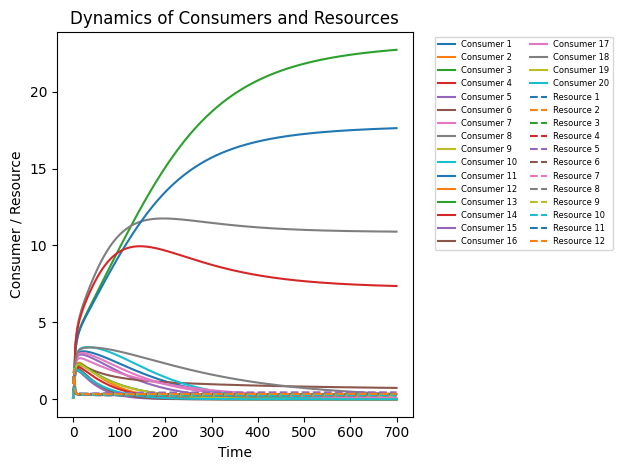

In [17]:
# Visualize system dynamics
for i in range(N):
    plt.plot(sol.t, sol.y[i], label=f'Consumer {i+1}')
for alpha in range(M):
    plt.plot(sol.t, sol.y[N + alpha], label=f'Resource {alpha+1}', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Consumer / Resource')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), ncol=2, fontsize=6, columnspacing=1.5)
plt.title('Dynamics of Consumers and Resources')
plt.tight_layout()
plt.savefig("results/dynamics_of_consumers_resources.png", dpi=300, bbox_inches='tight')
plt.show()
   

Figure 1: Dynamics of consumers and resources. It displays how population of species and amount of resources change in a system

## **Calculation of carbon usage efficiency**

### **Defination**

Carbon Use Efficiency (CUE) is a key ecological functional metric that describes the proportion of assimilated carbon allocated to biomass growth compared with total carbon uptake. It is commonly used in microbial ecology and soil carbon cycling to understand how organisms utilize carbon resources.

Usually it is defined as the ratio of growth (μ) to assimilation, that is, CUE = μ/(μ + R), where R includes any Carbon losses to respiration. However, depending on the research focus, the definition of CUE may vary across different contexts.

<div style="text-align: center;">
    <img src="CUE_definition.png" width="800">
</div>


Estimates are color coded by the type of sample analyzed: soil (black), water (blue), isotopologues in soil (red), calorespirometry in soil (green) and culture-based/thermodynamics (grey). CUEP examples depict glucose (or similar) amendment. CUE carbon use efficiency, Y yield, MB microbial biomass, R respiration, BGE bacterial growth efficiency, BP bacterial production, BR bacterial respiration, MGE microbial growth efficiency, SOC soil organic carbon, CCE carbon conversion efficiency, ΔG°cat, Gibbs energy of catabolism; ΔrG°x, Gibbs energy of growth; ΔG°an, Gibbs energy of anabolism. aLinton and Stephenson (1978), bGommers et al. (1988), cBabel (2009), dTannler et al.

https://doi.org/10.1007/s10533-016-0191-y

### **Species level CUE:**


Species’ carbon use efficiency (CUE, henceforth denoted by ε) reflects the resource utilisation ability of a species. It is  usually quantified as the partitioning of harvested resources into cell growth versus carbon loss mainly through  leakage and maintenance

$$
\varepsilon_j = \frac{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha} \left( 1 - l_{\alpha}^{j} \right) - m_{i}(T)}
{\sum_{\alpha=1}^{M} u_{i\alpha}(T) \hat{R}_{\alpha}}
$$

$$
\begin{array}{|c|c|}
\hline
\textbf{Symbol} & \textbf{Meaning} \\
\hline
u_{i\alpha}(T) & \text{Uptake coefficient} \\
\hat{R}_{\alpha} & \text{Resource availability} \\
l_{\alpha}^{j} & \text{Leakage fraction} \\
m_{i}(T) & \text{Maintenance cost} \\
M & \text{Total number of resources} \\
\hline
\end{array}
$$




In [18]:
# CUE
CUE = np.zeros(N)
total_uptake = np.sum(u * R0, axis=1)  # (N × M) @ (M,) -> (N,)
net_uptake = np.sum(u * R0 *(1-lambda_alpha), axis=1)-m # Adjusted for leakage and metabolism
CUE = net_uptake/total_uptake
print(f"Carbon Use Efficiency (CUE): {CUE.tolist()}")

Carbon Use Efficiency (CUE): [0.4775272811396074, 0.47038656996505324, 0.4909286991538908, 0.4596792234904996, 0.47643152705736636, 0.4619262583038154, 0.4768418150468277, 0.4995864343370033, 0.46028786309818964, 0.4805767578178892, 0.4914754029744522, 0.4578290653305363, 0.4658044164926794, 0.4949323926129202, 0.4569409395451154, 0.45954371319950466, 0.47634612948542415, 0.47912363410536374, 0.46736364047549556, 0.4597632271407262]


### **Community level CUE:**

#### **Experimental measurement**

In labs, the meaning of CUE is usually defined as the fraction of consumed carbon that is converted into new microbial biomass.

Some researchers(https://journals.asm.org/doi/10.1128/aem.01851-20) quantifiedhow much carbon had been assimilated into biomass versus how much was depleted from the medium. This was accomplished by measuring total carbon in the culture vs. carbon remaining in solution after removing cells.
The numerator is biomass, obtained by subtracting the carbon weight of the residual medium from the total carbon weight in the culture plate. The denominator is the amount of resource consumption from the previous time point to the current time point.


$$
\text{CUE} = \frac{C_{\text{unfiltered}}(t) - C_{\text{filtered}}(t)}{C_{\text{unfiltered}}(t-1) - C_{\text{unfiltered}}(t)}
$$

- $\displaystyle C_{\text{unfiltered}}(t)$ → Total carbon in the culture (cells + dissolved organic carbon) at time $t$.
- $\displaystyle C_{\text{filtered}}(t)$ → Carbon remaining in the medium after filtering out cells at time $t$.
- $\displaystyle C_{\text{unfiltered}}(t-1)$ → Total carbon in the previous time step $t-1$.


<div style="text-align: center;">
    <img src="1.jpeg" width="600">
</div>


Carbon use efficiency (CUE) during microbial growth of Paraburkholderia sp. 1N on SESOM. All points represent means with standard error bars (n = 3). Instantaneous CUE was calculated from growth in between biomass sampling points, so estimated values are displayed at the center of the measurement period. A similar 4-point sigmoidal curve was fit for cumulative CUE

https://journals.asm.org/doi/10.1128/aem.01851-20

Some others use the very original defination:
$$
CUE = \frac{\text{Growth Rate}}{\text{Growth Rate} + \text{Respiration Rate}}
$$

where the amount of CO2 -C produced during the incubation period was recorded as soil respiration flux. Isotope 18O was used for the measurement of DNA change and eventually growth rate

- The increase in DNA (\(\Delta DNA\)) was calculated as:

$$
\Delta DNA = 0.33 \times \frac{\text{at\%}^{18}O_{DNA_{labeled}} - \text{at\%}^{18}O_{DNA_{natural}}}{\text{at\%}^{18}O_{water} - \text{at\%}^{18}O_{DNA_{natural}}}
$$

- **DNA increment (\(\Delta DNA\))** was converted to **microbial biomass carbon (\(\Delta MBC\))** using a linear regression model:
$$
\Delta MBC = \beta \times \Delta DNA
$$

- The final **growth rate** was calculated as:
$$
\text{Growth Rate} = \frac{\Delta MBC}{t}
$$
where \( t \) is the incubation time (24 h).

#### **Simulation calculation**

##### **Method 1 Temporal Changes in Biomass and Resources**

The community level Carbon Use Efficiency (CUE) is calculated based on changes between current time points and initial state using the following formula:

$$
CUE = \frac{C_t - C_0}{R_0 - R_t + \text{inflow} \times t}
$$

where:
- $\displaystyle C_t$ is the carbon at time $t$,
- $\displaystyle C_0$ is the initial carbon,
- $\displaystyle R_t$ is the resource at time $t$,
- $\displaystyle R_0$ is the initial resource,
- $\displaystyle \text{inflow}$ is the resource inflow rate,
- $\displaystyle t$ is the elapsed time.

This formula captures the efficiency of carbon utilization over time.

In [19]:
# cumulative community CUE
C_values = sol.y[:N, :]
R_values = sol.y[N:, :]

# select fifty time points
time_indices = np.linspace(0, len(sol.t) - 1, 50, dtype=int)
C_selected = C_values[:, time_indices]
R_selected = R_values[:, time_indices]

In [20]:
# the cumulative change of resource and biomass compared to initial state
dR = R_selected.sum(axis=0) - R0.sum() + sol.t[time_indices] * 12
dR = dR[1:] 
dC = C_selected.sum(axis=0) - C0.sum()
dC = dC[1:] 

In [21]:
# calculate community level CUE
community_cue = dC/dR
# print output
for i, t_idx in enumerate(time_indices[1:]):
    print(f"Time: {sol.t[t_idx]:.2f}, community CUE: {community_cue[i]:.4f}")

Time: 14.05, community CUE: 0.3490
Time: 28.09, community CUE: 0.1755
Time: 42.14, community CUE: 0.1162
Time: 56.19, community CUE: 0.0868
Time: 70.23, community CUE: 0.0693
Time: 84.28, community CUE: 0.0576
Time: 98.33, community CUE: 0.0493
Time: 112.37, community CUE: 0.0431
Time: 126.42, community CUE: 0.0383
Time: 142.81, community CUE: 0.0339
Time: 156.86, community CUE: 0.0309
Time: 170.90, community CUE: 0.0283
Time: 184.95, community CUE: 0.0261
Time: 199.00, community CUE: 0.0243
Time: 213.04, community CUE: 0.0227
Time: 227.09, community CUE: 0.0213
Time: 241.14, community CUE: 0.0200
Time: 255.18, community CUE: 0.0189
Time: 269.23, community CUE: 0.0179
Time: 285.62, community CUE: 0.0169
Time: 299.67, community CUE: 0.0161
Time: 313.71, community CUE: 0.0154
Time: 327.76, community CUE: 0.0147
Time: 341.81, community CUE: 0.0141
Time: 355.85, community CUE: 0.0136
Time: 369.90, community CUE: 0.0131
Time: 383.95, community CUE: 0.0126
Time: 397.99, community CUE: 0.0121

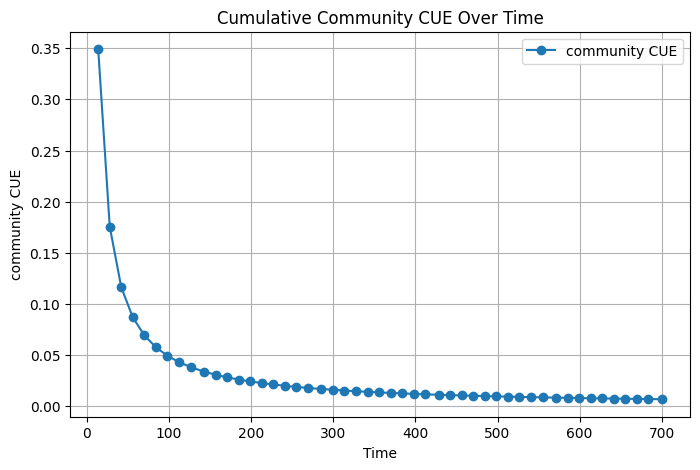

In [22]:
# visualization
plt.figure(figsize=(8, 5))
plt.plot(sol.t[time_indices[1:]], community_cue, marker='o', linestyle='-', label='community CUE')
plt.xlabel('Time')
plt.ylabel('community CUE')
plt.title('Cumulative Community CUE Over Time')
plt.legend()
plt.grid()
plt.show()

We are also able to calculate th instataneous CUE according to the change of resource and biomass between adjacent time points:
$$
CUE = \frac{C_t - C_(t-1)}{R_(t-1) - R_t + \text{inflow} \times \Delta t}
$$

Time: 14.05, community CUE: 0.0110
Time: 28.09, community CUE: 0.0090
Time: 42.14, community CUE: 0.0072
Time: 56.19, community CUE: 0.0057
Time: 70.23, community CUE: 0.0045
Time: 84.28, community CUE: 0.0035
Time: 98.33, community CUE: 0.0028
Time: 112.37, community CUE: 0.0022
Time: 126.42, community CUE: 0.0017
Time: 142.81, community CUE: 0.0011
Time: 156.86, community CUE: 0.0010
Time: 170.90, community CUE: 0.0008
Time: 184.95, community CUE: 0.0006
Time: 199.00, community CUE: 0.0005
Time: 213.04, community CUE: 0.0004
Time: 227.09, community CUE: 0.0003
Time: 241.14, community CUE: 0.0002
Time: 255.18, community CUE: 0.0002
Time: 269.23, community CUE: 0.0001
Time: 285.62, community CUE: 0.0001
Time: 299.67, community CUE: 0.0001
Time: 313.71, community CUE: 0.0001
Time: 327.76, community CUE: 0.0001
Time: 341.81, community CUE: 0.0000
Time: 355.85, community CUE: 0.0000
Time: 369.90, community CUE: 0.0000
Time: 383.95, community CUE: 0.0000
Time: 397.99, community CUE: 0.0000

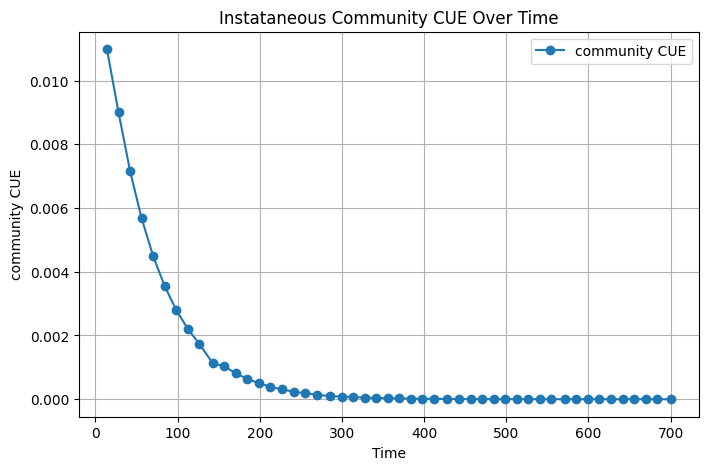

In [23]:
# calculate the instataneous community CUE between adjacent time points
dR2 = (R_selected[:-1].sum(axis=0) - R_selected[0:].sum(axis=0)) 
dR2 = dR2[1:] + 12 * (sol.t[time_indices[1:]] - sol.t[time_indices[:-1]])
dC2 = C_selected[0:].sum(axis=0) - C_selected[:-1].sum(axis=0)
dC2 = dC2 [1:] 
community_cue2 = dC2 / dR2
# print output
for i, t_idx in enumerate(time_indices[1:]):
    print(f"Time: {sol.t[t_idx]:.2f}, community CUE: {community_cue2[i]:.4f}")

# visualization
plt.figure(figsize=(8, 5))
plt.plot(sol.t[time_indices[1:]], community_cue2, marker='o', linestyle='-', label='community CUE')
plt.xlabel('Time')
plt.ylabel('community CUE')
plt.title('Instataneous Community CUE Over Time')
plt.legend()
plt.grid()
plt.show()

As the system approaches equilibrium, the community CUE also converges toward zero.

Current problem is how to define the equilibrium state. We could define it by the first time point when dC/dt first approach 0.

System reached steady state at t = 397.99
Steady-state Biomass (C): [2.02040906e-01 2.46360940e-03 2.07036197e+01 2.86312773e-03
 8.68411970e-02 8.88417591e-01 1.95065144e-01 1.11794107e+01
 3.23605379e-04 2.07350125e-01 1.67447520e+01 6.97875470e-04
 3.83652753e-02 8.07452692e+00 6.76419282e-05 2.21373317e-04
 3.61988718e-01 1.09002158e+00 3.56602747e-02 2.48840447e-03]
Steady-state Resources (R): [0.31685338 0.24736013 0.33282257 0.26665925 0.44654593 0.25124353
 0.28957927 0.26949864 0.29844953 0.2535134  0.33991318 0.34525293]


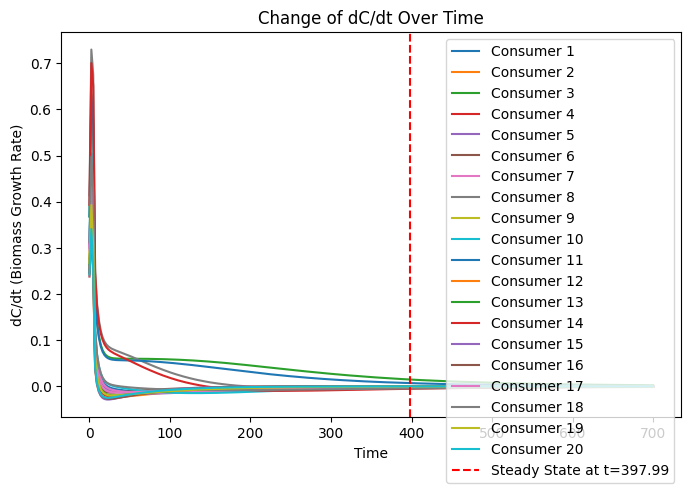

In [24]:
# Set the equilibrium threshold
tolerance = 0.015

# Compute the numerical derivative of dC/dt
dC_dt_numeric = np.gradient(sol.y[:N, :], sol.t, axis=1)  # (N, T)

# Step-by-step check to find the equilibrium state of R and CUE
t_steady = None
for idx in range(len(sol.t)):
    if np.all(np.abs(dC_dt_numeric[:, idx]) < tolerance):  # Check if all dC/dt values are below the threshold
        t_steady = sol.t[idx]  # Record the equilibrium time
        C_steady = sol.y[:N, idx]  # Record the steady-state biomass (C)
        R_steady = sol.y[N:, idx]  # Record the steady-state resource abundance (R)
        break  # Stop searching once equilibrium is found

# Print the results
if t_steady is not None:
    print(f"System reached steady state at t = {t_steady:.2f}")
    print(f"Steady-state Biomass (C): {C_steady}")
    print(f"Steady-state Resources (R): {R_steady}")
else:
    print("System did not reach steady state within the simulation time.")

# Plot the change of dC/dt over time
plt.figure(figsize=(8, 5))
for i in range(N):
    plt.plot(sol.t, dC_dt_numeric[i], label=f'Consumer {i+1}')
if t_steady is not None:
    plt.axvline(x=t_steady, color='r', linestyle='--', label=f'Steady State at t={t_steady:.2f}')
plt.xlabel("Time")
plt.ylabel("dC/dt (Biomass Growth Rate)")
plt.title("Change of dC/dt Over Time")
plt.legend()
plt.show()

In [25]:
# community CUE
# Compute total resource consumed by consumers
total_resource_consumed = np.sum(rho) *t_steady  - np.sum(R_steady)
# Compute biomass growth
biomass_growth = np.sum(C_steady) - np.sum(C0)
CUE_community = biomass_growth/total_resource_consumed
print(f"Community-level Carbon Use Efficiency (CUE): {CUE_community:.4f}")

Community-level Carbon Use Efficiency (CUE): 0.0121


##### **Method 2 Distribution of species CUE**

The distribution of CUE value of each species can also more or less represent the community level carbon usage efficiency.

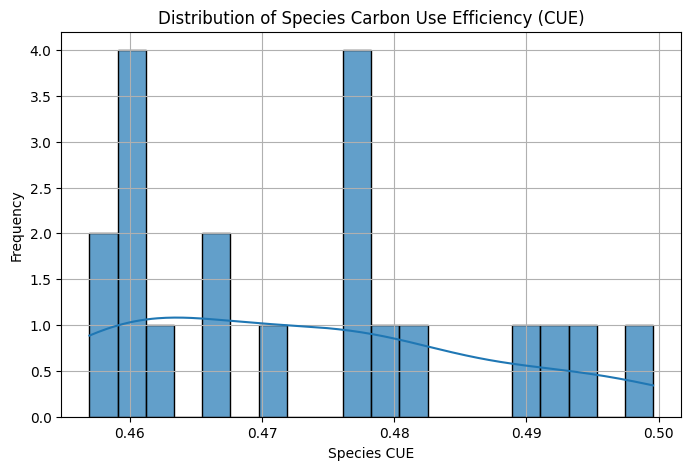

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(CUE, bins=20, kde=True, edgecolor='black', alpha=0.7)
plt.xlabel("Species CUE")
plt.ylabel("Frequency")
plt.title("Distribution of Species Carbon Use Efficiency (CUE)")
plt.grid(True)
plt.show()

However, in most cases, **different species contribute unequally to the community** because of variation in species abundance and uneven distribution of functional traits.

Community CUE is mostly influenced by dominant or high abundance species. For example, if a species has a low CUE and is rare, its effect on community CUE is much smaller than that of a high-CUE, high-abundance species.

### **Community-level characterization**

We aim to identify traits that may influence coalescence outcomes, as our focus is coalescence of different functional groups rather than different strains. Therefore, it is crucial to find some traits influencing community structure or function.

#### CUE

Carbon usage efficiency reflects the ability to deplete resources and has been shown to be strongly correlated with species survival and extinction during community assembly. We look forward to similar pattern during coalescence.

There is also a connection between species richness and variance of species level CUE. Lower variance allows the space for more species to coexist, leading to high richness.

![Screenshot from 2025-03-05 11-15-31.png](<attachment:Screenshot from 2025-03-05 11-15-31.png>)
![Screenshot from 2025-03-05 11-21-43.png](<attachment:Screenshot from 2025-03-05 11-21-43.png>)
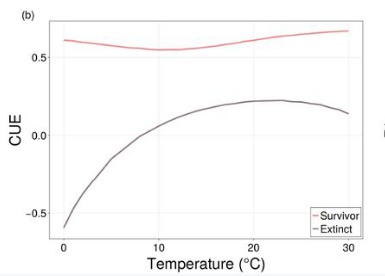
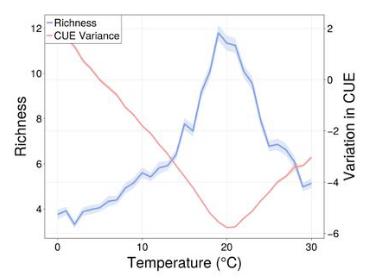

https://doi.org/10.32388/M1XFXL

#### Niche overlap

According to competitive exclusion principle, species competing for identical resources connot stably coexist. Niche partition, which means species utilizing different resources, leading to coexistence. In our model, the niche partition could be controled by the function 
>u = param_3D.modular_uptake(N, M, N_modules, s_ratio, λ_u, σ)  


Divide the resources into different groups `N_modules` and assign different consumers to specialize in specific resource groups, while also controlling the degree of specialization `s_ratio`.
We can get the resource uptake distribution for each species and assess their similarity.

#### Interaction coefficient

The effective interaction coefficients of the ELV system is 
$$
\alpha_{ij} = \sum_{a} u_{ia} (1 - l_{a}^{i}) \frac{\partial \hat{R}_a}{\partial C_j}
$$

In our system we will get a matrix and it illustrates the pairwise interaction between different species. If it's positive, it means the relationship among these two species is cooperative and negative indicating competitive. 
The abundance change of species j will affect species i indirectly through resource

#### Abundance

Native species abundance regulates resistance to non-native invasions. Resident species with higher abundance are more resistant to invasion because they leave little niche space for an invader to occupy.
https://doi.org/10.1093/forsci/fxy059

The initial abundance of an invading microbe (propagule pressure) is a critical determinant of invasion success. Generally, the more invader cells or propagules introduced, the higher the chance that some will survive competition and establish a population. 

Is there chances for rare species? (Think about niche space or enemy release hypothesis)?

Some researchers tried to combine three-pronged framework of traits of invador, environmental context, and propagule pressure together to make some prediction about invasive event.
https://doi.org/10.1038/s44185-023-00019-1

#### Network structure